In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score

# Plot style similar to UCI_NN
plt.style.use("dark_background")

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:

df = pd.read_csv("student-por.csv", sep=";")
print(df.shape)
df.head()


(649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:

data = df.copy()

reg_target = "G3"
cls_target = "romantic"

yes_no_cols = ["schoolsup","famsup","paid","activities","nursery",
               "higher","internet","romantic"]

for col in yes_no_cols:
    data[col] = data[col].map({"no": 0, "yes": 1})

y_grade = data[reg_target].astype(np.float32).values
y_romantic = data[cls_target].astype(np.int64).values

X = data.drop(columns=[reg_target, cls_target])

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values.astype(np.float32))

input_dim = X_scaled.shape[1]
input_dim


40

In [4]:

X_train, X_temp, y_grade_train, y_grade_temp, y_romantic_train, y_romantic_temp = train_test_split(
    X_scaled, y_grade, y_romantic,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=y_romantic
)

X_val, X_test, y_grade_val, y_grade_test, y_romantic_val, y_romantic_test = train_test_split(
    X_temp, y_grade_temp, y_romantic_temp,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=y_romantic_temp
)

len(X_train), len(X_val), len(X_test)


(454, 97, 98)

In [5]:

class StudentDataset(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_grade = torch.tensor(y_grade, dtype=torch.float32)
        self.y_romantic = torch.tensor(y_romantic, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]


train_ds = StudentDataset(X_train, y_grade_train, y_romantic_train)
val_ds   = StudentDataset(X_val,   y_grade_val,   y_romantic_val)
test_ds  = StudentDataset(X_test,  y_grade_test,  y_romantic_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)


(454, 97, 98)

In [6]:

class MultiTaskNet(nn.Module):
    def __init__(self, input_dim, hidden_body=128, hidden_head=64):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_dim, hidden_body),
            nn.BatchNorm1d(hidden_body),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_body, hidden_head),
            nn.BatchNorm1d(hidden_head),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        self.head_reg = nn.Sequential(
            nn.Linear(hidden_head, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.head_cls = nn.Sequential(
            nn.Linear(hidden_head, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        shared = self.body(x)
        grade = self.head_reg(shared).squeeze(-1)
        romantic_logits = self.head_cls(shared)
        return grade, romantic_logits


model = MultiTaskNet(input_dim).to(device)
model


MultiTaskNet(
  (body): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
  )
  (head_reg): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (head_cls): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [7]:

def train_one_epoch(model, loader, optimizer, mse_loss, ce_loss, alpha, device):
    model.train()
    total_loss = 0.0
    total_g = 0.0
    total_r = 0.0
    n = 0

    for Xb, yg, yr in loader:
        Xb = Xb.to(device)
        yg = yg.to(device)
        yr = yr.to(device)

        optimizer.zero_grad()
        pred_g, pred_r_logits = model(Xb)

        loss_g = mse_loss(pred_g, yg)
        loss_r = ce_loss(pred_r_logits, yr)
        loss = alpha * loss_g + (1.0 - alpha) * loss_r

        loss.backward()
        optimizer.step()

        bs = Xb.size(0)
        total_loss += loss.item() * bs
        total_g += loss_g.item() * bs
        total_r += loss_r.item() * bs
        n += bs

    return total_loss / n, total_g / n, total_r / n


def eval_one_epoch(model, loader, mse_loss, ce_loss, alpha, device):
    model.eval()
    total_loss = 0.0
    total_g = 0.0
    total_r = 0.0
    n = 0

    with torch.inference_mode():
        for Xb, yg, yr in loader:
            Xb = Xb.to(device)
            yg = yg.to(device)
            yr = yr.to(device)

            pred_g, pred_r_logits = model(Xb)

            loss_g = mse_loss(pred_g, yg)
            loss_r = ce_loss(pred_r_logits, yr)
            loss = alpha * loss_g + (1.0 - alpha) * loss_r

            bs = Xb.size(0)
            total_loss += loss.item() * bs
            total_g += loss_g.item() * bs
            total_r += loss_r.item() * bs
            n += bs

    return total_loss / n, total_g / n, total_r / n


In [8]:

def plot_history(history, title_prefix=""):
    epochs = np.arange(1, len(history['train_total']) + 1)

    # Total loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history['train_total'], label='Train Total Loss')
    plt.plot(epochs, history['val_total'], label='Val Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title(title_prefix + 'Total Loss: Train vs Validation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Grade loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history['train_g'], label='Train Grade Loss')
    plt.plot(epochs, history['val_g'], label='Val Grade Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Grade Loss')
    plt.title(title_prefix + 'Grade (G3) Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Romantic loss
    plt.figure(figsize=(8,5))
    plt.plot(epochs, history['train_r'], label='Train Romantic Loss')
    plt.plot(epochs, history['val_r'], label='Val Romantic Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Romantic Loss')
    plt.title(title_prefix + 'Romantic Status Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:

def train_model(alpha=0.5, num_epochs=40, lr=1e-3, weight_decay=1e-4, verbose=True):
    model = MultiTaskNet(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    history = {
        "train_total": [], "val_total": [],
        "train_g": [], "val_g": [],
        "train_r": [], "val_r": [],
    }

    best_val = float("inf")
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_total, train_g, train_r = train_one_epoch(
            model, train_loader, optimizer, mse_loss, ce_loss, alpha, device
        )
        val_total, val_g, val_r = eval_one_epoch(
            model, val_loader, mse_loss, ce_loss, alpha, device
        )

        history["train_total"].append(train_total)
        history["val_total"].append(val_total)
        history["train_g"].append(train_g)
        history["val_g"].append(val_g)
        history["train_r"].append(train_r)
        history["val_r"].append(val_r)

        if verbose:
            print(f"α={alpha:.2f} | Epoch {epoch:02d} | "
                  f"Train total: {train_total:.4f} | Val total: {val_total:.4f} | "
                  f"G(val): {val_g:.4f} | R(val): {val_r:.4f}")

        if val_total < best_val:
            best_val = val_total
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


def evaluate_on_test(model, loader, device):
    model.eval()
    all_true_g, all_pred_g = [], []
    all_true_r, all_pred_r = [], []

    with torch.inference_mode():
        for Xb, yg, yr in loader:
            Xb = Xb.to(device)
            yg = yg.to(device)
            yr = yr.to(device)

            pred_g, pred_r_logits = model(Xb)
            pred_r = torch.argmax(pred_r_logits, dim=1)

            all_true_g.append(yg.cpu().numpy())
            all_pred_g.append(pred_g.cpu().numpy())
            all_true_r.append(yr.cpu().numpy())
            all_pred_r.append(pred_r.cpu().numpy())

    all_true_g = np.concatenate(all_true_g)
    all_pred_g = np.concatenate(all_pred_g)
    all_true_r = np.concatenate(all_true_r)
    all_pred_r = np.concatenate(all_pred_r)

    mae = mean_absolute_error(all_true_g, all_pred_g)
    acc = accuracy_score(all_true_r, all_pred_r)
    f1 = f1_score(all_true_r, all_pred_r, average="binary")

    return mae, acc, f1


α=0.50 | Epoch 01 | Train total: 77.1205 | Val total: 74.5566 | G(val): 148.4350 | R(val): 0.6782
α=0.50 | Epoch 02 | Train total: 73.4284 | Val total: 72.3836 | G(val): 144.0959 | R(val): 0.6712
α=0.50 | Epoch 03 | Train total: 69.3716 | Val total: 69.0121 | G(val): 137.3588 | R(val): 0.6653
α=0.50 | Epoch 04 | Train total: 65.0587 | Val total: 64.8037 | G(val): 128.9461 | R(val): 0.6614
α=0.50 | Epoch 05 | Train total: 59.6574 | Val total: 59.6668 | G(val): 118.6748 | R(val): 0.6589
α=0.50 | Epoch 06 | Train total: 54.3100 | Val total: 53.6457 | G(val): 106.6331 | R(val): 0.6584
α=0.50 | Epoch 07 | Train total: 47.6073 | Val total: 47.6291 | G(val): 94.6024 | R(val): 0.6558
α=0.50 | Epoch 08 | Train total: 39.7523 | Val total: 40.3620 | G(val): 80.0709 | R(val): 0.6530
α=0.50 | Epoch 09 | Train total: 32.9643 | Val total: 33.1768 | G(val): 65.7006 | R(val): 0.6530
α=0.50 | Epoch 10 | Train total: 25.6999 | Val total: 27.3272 | G(val): 54.0038 | R(val): 0.6505
α=0.50 | Epoch 11 | Trai

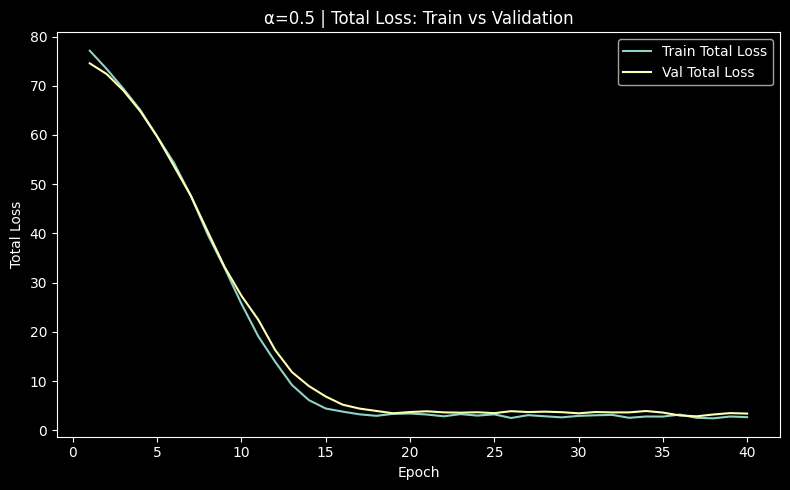

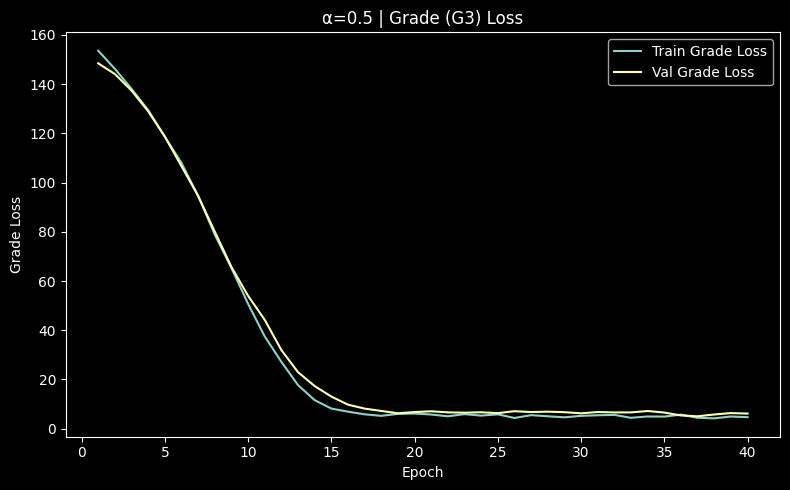

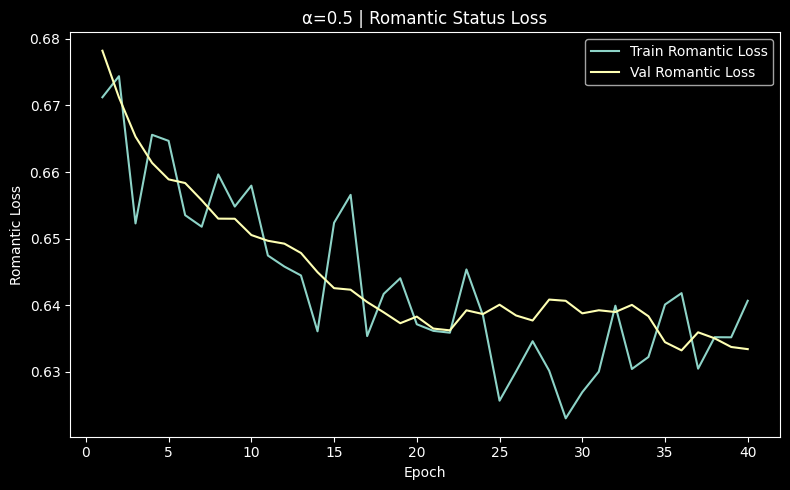

Baseline Test MAE: 1.8843
Baseline Test Accuracy: 0.6224
Baseline Test F1-score: 0.0976


In [10]:

alpha_baseline = 0.5
model_baseline, history_baseline = train_model(alpha=alpha_baseline, num_epochs=40)

plot_history(history_baseline, title_prefix=f"α={alpha_baseline} | ")

mae_baseline, acc_baseline, f1_baseline = evaluate_on_test(model_baseline, test_loader, device)
print(f"Baseline Test MAE: {mae_baseline:.4f}")
print(f"Baseline Test Accuracy: {acc_baseline:.4f}")
print(f"Baseline Test F1-score: {f1_baseline:.4f}")


In [11]:

alphas = [0.2, 0.5, 0.8]
results = []

for alpha in alphas:
    print(f"Training model with α = {alpha}")
    model_a, hist_a = train_model(alpha=alpha, num_epochs=25, verbose=False)
    mae, acc, f1 = evaluate_on_test(model_a, test_loader, device)
    results.append((alpha, mae, acc, f1))
    print(f"Test MAE: {mae:.4f} | Test Acc: {acc:.4f} | Test F1: {f1:.4f}")

results_df = pd.DataFrame(results, columns=["alpha", "test_mae", "test_acc", "test_f1"])
results_df


Training model with α = 0.2
Test MAE: 2.4177 | Test Acc: 0.6531 | Test F1: 0.2609
Training model with α = 0.5
Test MAE: 2.1267 | Test Acc: 0.6327 | Test F1: 0.1429
Training model with α = 0.8
Test MAE: 1.9179 | Test Acc: 0.6633 | Test F1: 0.1538


,alpha,test_mae,test_acc,test_f1
0,0.2,2.417728,0.653061,0.260870
1,0.5,2.126735,0.632653,0.142857
2,0.8,1.917917,0.663265,0.153846


In [12]:

MODEL_PATH = "multitask_student_model_alpha_0.5.pt"
torch.save(model_baseline.state_dict(), MODEL_PATH)
MODEL_PATH


'multitask_student_model_alpha_0.5.pt'